In [1]:
# Import Packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import silhouette_score, silhouette_samples,f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

import optuna
import scipy.cluster
from sklearn.pipeline import Pipeline

import datetime
import os

from sklearn.model_selection import cross_val_score,train_test_split
from catboost import CatBoostClassifier

from sklearn.feature_selection import SelectKBest, f_classif

c:\Users\jcen\azuredatastudio-python\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\jcen\azuredatastudio-python\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\jcen\azuredatastudio-python\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:

dir = './Dataset/'
file_path = os.path.join(dir, 'credit_default.csv')

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print("File not found: data.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   UserID             6000 non-null   object
 1   Sex                6000 non-null   object
 2   PreviousDefault    6000 non-null   int64 
 3   FirstName          6000 non-null   object
 4   LastName           6000 non-null   object
 5   NumberPets         6000 non-null   int64 
 6   PreviousAccounts   6000 non-null   int64 
 7   ResidenceDuration  6000 non-null   int64 
 8   Street             6000 non-null   object
 9   LicensePlate       6000 non-null   object
 10  BadCredit          6000 non-null   int64 
 11  Amount             6000 non-null   int64 
 12  Married            6000 non-null   int64 
 13  Duration           6000 non-null   int64 
 14  City               6000 non-null   object
 15  Purpose            6000 non-null   object
 16  DateOfBirth        6000 non-null   object


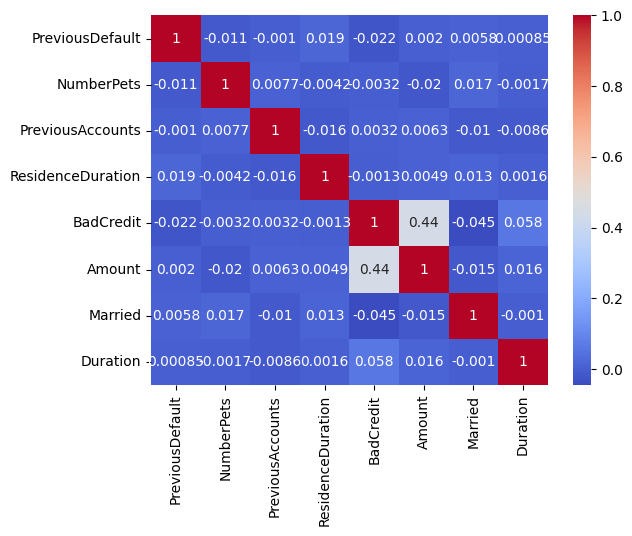

In [4]:
# Correlation Analysis
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

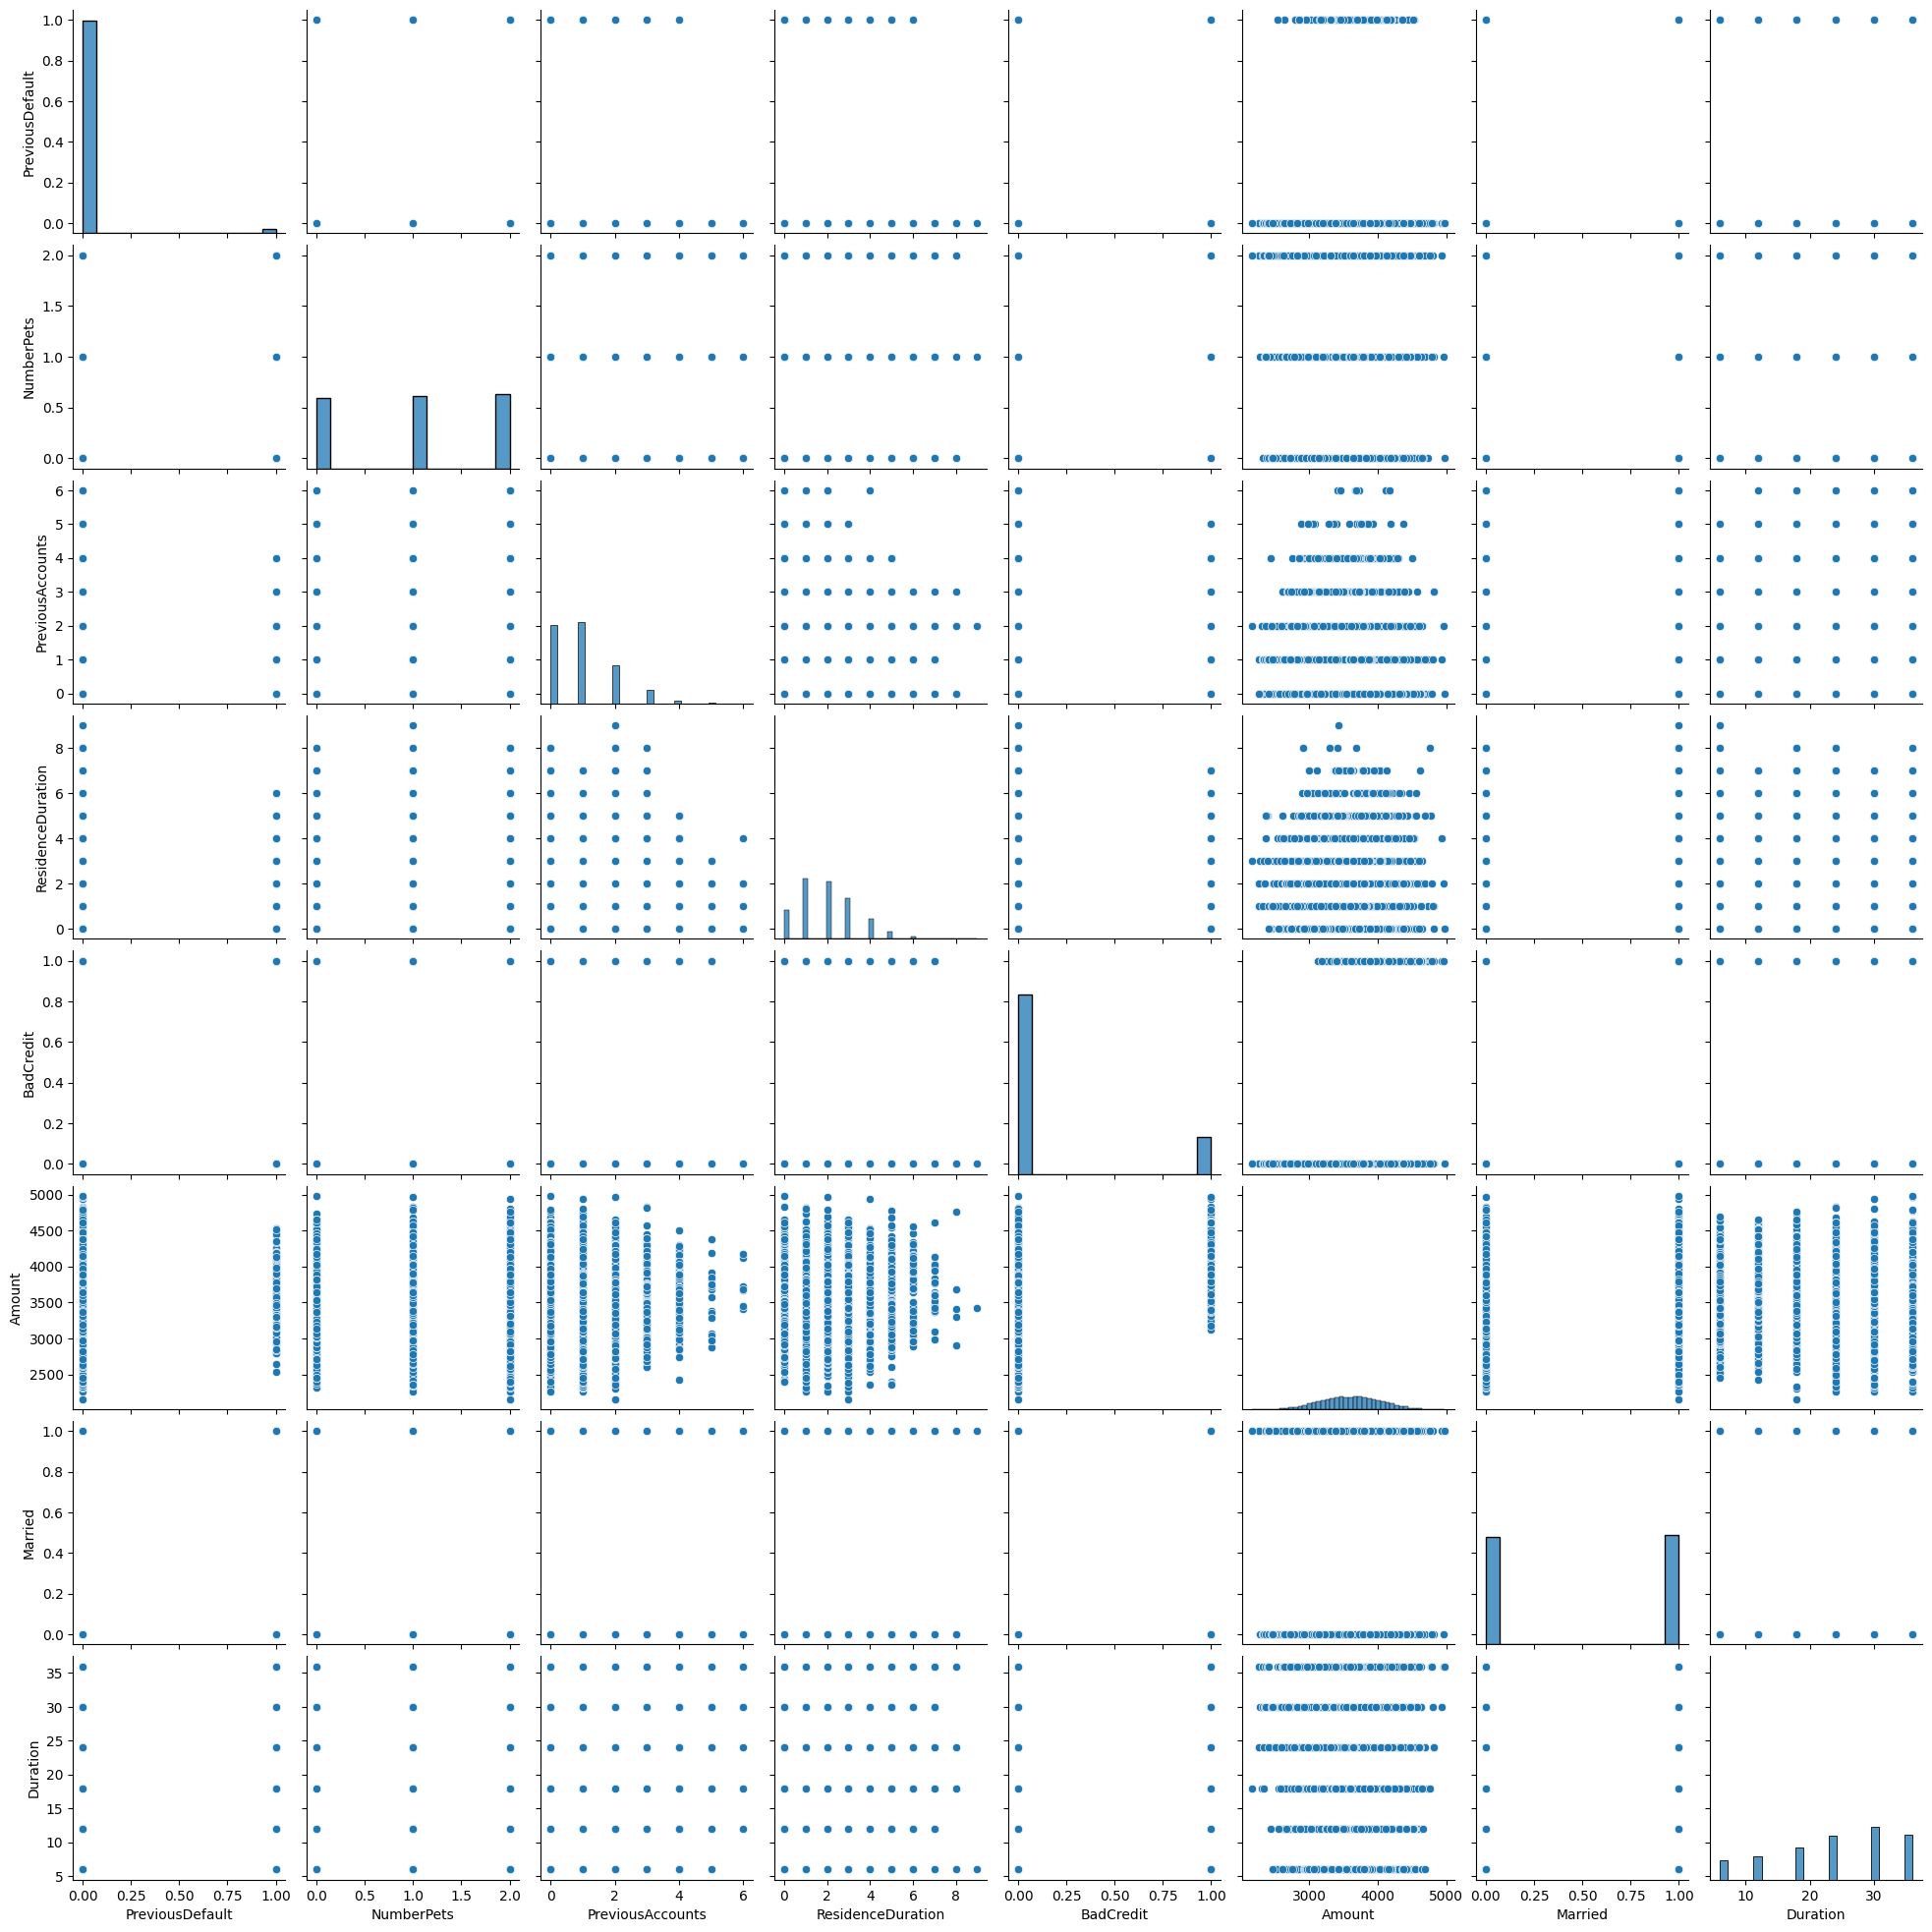

In [5]:
sns.pairplot(df)
plt.show()

In [6]:

X = df.drop('BadCredit', axis=1) #.select_dtypes(['number'])
y = df['BadCredit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Engineering

Two Features Added:
1. Age baesd on DOB
2. Interaction varaiable based on duration and amount

In [7]:
def feature_eng(df):
  temp_df =df.copy()

  # Add age based on DOB
  today = datetime.datetime.now()
  temp_df['DateOfBirth'] = pd.to_datetime(temp_df['DateOfBirth'])
  # today = datetime.now()
  temp_df['age'] = today.year - temp_df['DateOfBirth'].dt.year
  # interaction varaible
  temp_df['duration_plus_amount'] = temp_df['Duration'] + temp_df['Amount']
  temp_df['duration_minus_amount'] = temp_df['Duration'] - temp_df['Amount']
  temp_df['duration_multi_amount'] = temp_df['Duration'] * temp_df['Amount']
  temp_df['duration_div_amount'] = temp_df['Duration'] / temp_df['Amount']

  return temp_df

In [8]:
X_train = feature_eng(X_train)
X_test = feature_eng(X_test)

## Create a baseline model just to checkout how things are going

In [9]:
# Columns to drop and to apply one-hot encoding
columns_to_drop = ['UserID','FirstName','LastName','Street','LicensePlate','DateOfBirth','Duration','Amount']
columns_to_encode = ['Sex','City','Purpose']
num_columns =['PreviousDefault', 'NumberPets', 'PreviousAccounts',
       'ResidenceDuration', 'Amount', 'Married', 'Duration', 'age',
       'duration_plus_amount', 'duration_minus_amount',
       'duration_multi_amount', 'duration_div_amount']
# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop),
        ('onehot', OneHotEncoder(), columns_to_encode),
        ('scaler', StandardScaler(),num_columns),
    ],
    remainder='passthrough'  # keeps the columns not specified in transformers
)
# Define the CatBoost model
catboost_model = CatBoostClassifier(verbose=False)
# Create pipeline
pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', catboost_model)])


# Perform cross-validation and then calculate scores
scores = cross_val_score(pipeline_2, X_train, y_train, cv=5,scoring="f1")

# Output the mean accuracy
print(f"Mean CV F1: {scores.mean():.2f}")

Mean CV F1: 0.63


## Hyperparameter tuning

In [10]:
def objective(trial,X,y):
    # Hyperparameters to tune
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),  # CatBoost uses 'depth' instead of 'num_leaves'
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'max_bin': trial.suggest_int('max_bin', 100, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 5),  # Similar to 'lambda_l1' and 'lambda_l2'
        # Fixed parameters
        'iterations': 1000,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
        # Add other parameters as needed
    }
    # Feature selection
    k = trial.suggest_int('k', 16, 42)

    columns_to_drop = ['UserID','FirstName','LastName','Street','LicensePlate','DateOfBirth','Duration','Amount']
    columns_to_encode = ['Sex','City','Purpose']
    num_columns =['PreviousDefault', 'NumberPets', 'PreviousAccounts',
          'ResidenceDuration', 'Amount', 'Married', 'Duration', 'age',
          'duration_plus_amount', 'duration_minus_amount',
          'duration_multi_amount', 'duration_div_amount']
    # Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('drop', 'drop', columns_to_drop),
            ('onehot', OneHotEncoder(), columns_to_encode),
            ('scaler', StandardScaler(),num_columns),
        ],
        remainder='passthrough'  # keeps the columns not specified in transformers
    )

    # Pipeline definition
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', CatBoostClassifier(verbose=False, **param))
    ])


    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="f1")


    return np.mean(scores)


# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100,  gc_after_trial=True)


print(study.best_params)

[I 2024-02-28 15:46:07,120] A new study created in memory with name: no-name-2f225d80-6665-4503-a02b-db698d020dad
[I 2024-02-28 15:47:21,502] Trial 0 finished with value: 0.6145671451589055 and parameters: {'learning_rate': 0.26917294882597903, 'depth': 9, 'min_data_in_leaf': 4, 'max_bin': 154, 'l2_leaf_reg': 0.10253682072076942, 'k': 31}. Best is trial 0 with value: 0.6145671451589055.
[W 2024-02-28 15:49:37,023] Trial 1 failed with parameters: {'learning_rate': 0.2054718906061314, 'depth': 10, 'min_data_in_leaf': 50, 'max_bin': 239, 'l2_leaf_reg': 4.569004541012982, 'k': 42} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\jcen\azuredatastudio-python\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-10-f9a8bca2269b>", line 53, in <lambda>
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100,  gc_after_trial=True)
  File "<

KeyboardInterrupt: 

## Inference On Test Dataset

In [ ]:
# Columns to drop and to apply one-hot encoding
columns_to_drop = ['UserID','FirstName','LastName','Street','LicensePlate','DateOfBirth','Duration','Amount']
columns_to_encode = ['Sex','City','Purpose']
num_columns =['PreviousDefault', 'NumberPets', 'PreviousAccounts',
      'ResidenceDuration', 'Amount', 'Married', 'Duration', 'age',
      'duration_plus_amount', 'duration_minus_amount',
      'duration_multi_amount', 'duration_div_amount']

param = {'learning_rate': 0.017848796719827066,
         'depth': 8,
         'min_data_in_leaf': 23,
         'max_bin': 227,
         'l2_leaf_reg': 1.3500782404915328,

         'iterations': 1000,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
         'verbose':False,}
# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop),
        ('onehot', OneHotEncoder(), columns_to_encode),
        ('scaler', StandardScaler(),num_columns),
    ],
    remainder='passthrough'  # keeps the columns not specified in transformers
)
# Define the CatBoost model
catboost_model = CatBoostClassifier(**param)
# Create pipeline
pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('feature_selection', SelectKBest(score_func=f_classif, k=40)),
                           ('classifier', catboost_model)])


# fit
pipeline_2.fit(X_train, y_train)
X_test = feature_eng(X_test)

predict = pipeline_2.predict(X_test)
f1_score(y_test, predict)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# use a range
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

from sklearn.preprocessing import StandardScaler
#use mean and std
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

# consider using log for power law distributions with long tails or buketize 

In [ ]:
# multinomial features (have multiple peaks), generate new features using rbf kernel
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)